In [39]:
import pandas as pd
import sqlite3
import re
import sqlite3, numpy as np
import matplotlib.pyplot as plt

In [40]:
import sqlite3, pandas as pd
con = sqlite3.connect('CoffeeShop_Dataset.db')

# 1. Generasi Z lebih suka teh atau kopi?

In [46]:
#muat data
def muat(n): return pd.read_sql_query(f"SELECT * FROM '{n}';", con)
df_sales = muat("sales reciepts")
df_prod  = muat("product")
df_cust  = muat("customer")
df_gen   = muat("generations")
df_out   = muat("sales outlet")
for d in (df_sales, df_prod, df_cust, df_gen):
    d.columns = [c.strip().lower() for c in d.columns]

In [49]:
# kategori min
def kategori_min(row):
    g = (row.get("product_group") or "").lower()
    p = (row.get("product") or "").lower()
    if ("coffee" in g) or any(w in p for w in ["espresso","latte","americano","cappuccino","mocha"]):
        return "Kopi"
    if ("tea" in g) or any(w in p for w in ["tea","chai","matcha","oolong"]):
        return "Teh"
    return None

df_prod["kategory"] = df_prod.apply(kategori_min, axis=1)

In [32]:
d = (df_sales.merge(df_prod[["product_id","kategory"]], on="product_id", how="left")
             .merge(df_cust[["customer_id","birth_year"]], on="customer_id", how="left"))
mapper_gen = dict(zip(df_gen["birth_year"], df_gen["generation"]))
def to_gen(y):
    try: return mapper_gen.get(int(y), "Unknown")
    except: return "Unknown"
d["_generation"] = d["birth_year"].apply(to_gen)
d["quantity"] = pd.to_numeric(d["quantity"], errors="coerce").fillna(0)

In [35]:
subset = d[(d["_generation"]=="Gen Z") & (d["kategory"].isin(["Kopi","Teh"]))].copy()
qty = subset.groupby("kategory")["quantity"].sum().reindex(["Kopi","Teh"]).fillna(0)
total = float(qty.sum())
share = (qty/total*100).round(2) if total>0 else qty
hasil = pd.DataFrame({"qty": qty.astype(int), "persentase %": share})
print("Perbandingan Kopi vs Teh:\n", hasil)

Perbandingan Kopi vs Teh:
            qty  persentase %
kategory                    
Kopi       618         35.64
Teh       1116         64.36


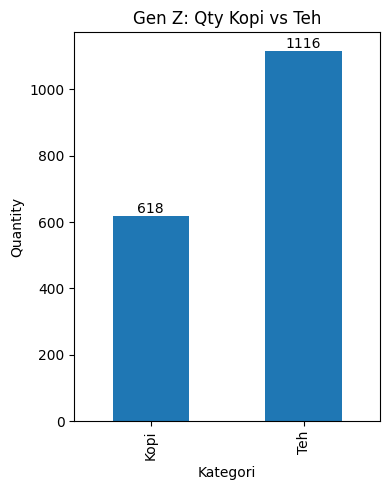

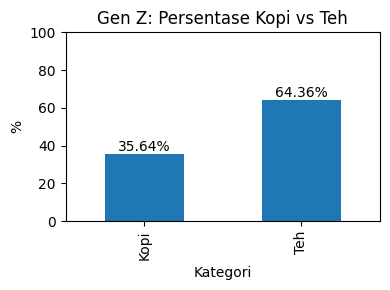

In [36]:
plt.figure(figsize=(4,5))
ax1 = qty.plot(kind="bar")
ax1.set_title("Gen Z: Qty Kopi vs Teh")
ax1.set_xlabel("Kategori"); ax1.set_ylabel("Quantity")
for i, v in enumerate(qty.values):
    ax1.text(i, v, f"{int(v)}", ha="center", va="bottom")
plt.tight_layout(); plt.show()

plt.figure(figsize=(4,3))
ax2 = share.plot(kind="bar")
ax2.set_title("Gen Z: Persentase Kopi vs Teh")
ax2.set_xlabel("Kategori"); ax2.set_ylabel("%"); ax2.set_ylim(0, 100)
for i, v in enumerate(share.values):
    ax2.text(i, v, f"{v:.2f}%", ha="center", va="bottom")
plt.tight_layout(); plt.show()

# 2. Total Transaksi & Total Revenue

In [54]:
total_trx = df_sales['transaction_id'].nunique()
total_rev = df_sales['line_item_amount'].sum()
print({'total_transaksi': int(total_trx), 'total_revenue': round(total_rev, 2)})

{'total_transaksi': 4203, 'total_revenue': np.float64(233635.95)}


# 3. Top-5 Produk Terlaris by Quantity

In [17]:
sales_prod = df_sales.merge(df_prod[['product_id','product']], on='product_id', how='left')
top5_produk = (sales_prod.groupby('product')['quantity'].sum().sort_values(ascending=False).head(5))
print(top5_produk)


product
Earl Grey Rg               1558
Dark chocolate Lg          1546
Latte                      1531
Morning Sunrise Chai Rg    1513
Ethiopia Rg                1506
Name: quantity, dtype: int64


# 4. Tampilkan Jumlah Transaksi per Tanggal

In [18]:
by_day = (df_sales.assign(date=pd.to_datetime(df_sales['transaction_date'], errors='coerce').dt.date).groupby('date')['transaction_id'].nunique().sort_index())
print(by_day)


date
2019-04-01    1193
2019-04-02    1171
2019-04-03    1224
2019-04-04    1159
2019-04-05    1172
2019-04-06    1077
2019-04-07     514
2019-04-08     480
2019-04-09     505
2019-04-10     487
2019-04-11     452
2019-04-12     489
2019-04-13     509
2019-04-14     477
2019-04-15    1132
2019-04-16    1153
2019-04-17    1087
2019-04-18    1098
2019-04-19    1116
2019-04-20     751
2019-04-21     768
2019-04-22    1223
2019-04-23    1234
2019-04-24    1303
2019-04-25    1236
2019-04-26    1256
2019-04-27     971
2019-04-28    1033
2019-04-29     961
Name: transaction_id, dtype: int64


# 5. mencari jam puncak (peak hour) untuk setiap outlet

In [63]:
peak_per_outlet = (sales_prod.groupby(['sales_outlet_id','hour'])['transaction_id'].nunique().reset_index(name='orders')
                               .sort_values(['sales_outlet_id','orders'], ascending=[True,False])
                               .groupby('sales_outlet_id').head(1))
print(peak_per_outlet)  # tiap outlet: jam puncak & jumlah order

    sales_outlet_id  hour  orders
9                 3    16     832
19                5     7     859
35                8     8     982


# 6. Tampilkan 5 Pastry terlaris

In [45]:
def is_pastry(r):
    g=(r.get('product_group') or '').lower(); c=(r.get('product_category') or '').lower()
    t=(r.get('product_type') or '').lower();   p=(r.get('product') or '').lower()
    return ('food' in g) or ('bakery' in c) or ('pastry' in t) or any(w in p for w in ['croissant','scone','muffin','cookie','cake','bread','biscotti'])
pastry = sales_prod[ sales_prod.apply(is_pastry, axis=1) ]
top5_pastry = pastry.groupby('product')['quantity'].sum().sort_values(ascending=False).head(5)
print(top5_pastry)

product
Chocolate Croissant    1040
Ginger Scone            872
Jumbo Savory Scone      685
Cranberry Scone         684
Hazelnut Biscotti       676
Name: quantity, dtype: int64
